# Notebook to extract the max of Specific heat

In [8]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interp', 'style']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


unitcell-2_p-2.0_nv-2_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\unitcell-2_p-2.0_nv-2_h-0.free-energy.h5
C_V max.: 0.45359082
Temp. at C_V max.: 0.83341475


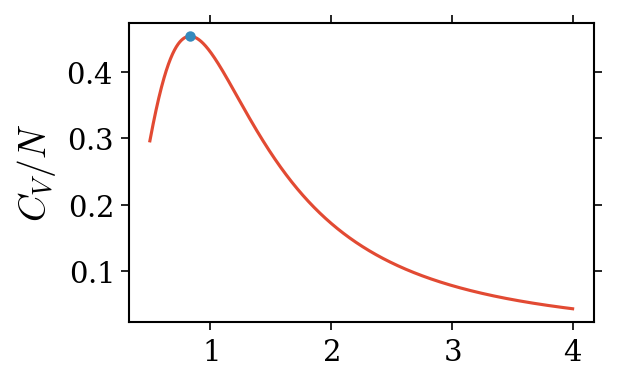

In [9]:
data_path = Path("../../data/imperfect/infinite-size/unitcell_2/ratio_1.5/p_2.0").resolve()
file = "unitcell-2_p-2.0_nv-2_h-0.yml"
try:
    config_file = Path(os.path.join(data_path,file)).resolve()
    energy_file = config_file.with_suffix(".free-energy.h5")
    print(file)
    print(energy_file)

    with config_file.open() as cfp:
        config_info = yaml.load(cfp)
    config_data = read_ising_config(config_info)

    with h5py.File(str(energy_file)) as h5fp:
        data_energy = h5fp["/free-energy"][()]

    temp = config_data["system"]["temperature"]
    mag_field = config_data["system"]["magnetic_field"]
    free_erg = data_energy[:, :]
        
    # Zero magnetic field spline
    free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                               free_erg[:, 0],
                                               s=0, k=4)
    temp_fine = np.linspace(temp.min(), temp.max(), 2048)

    # Second derivative of the free energy.
    free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
    cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
    cv_max_idx = np.argmax(cv_fine)
    temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

    print(f"C_V max.: {cv_max:.8G}")
    print(f"Temp. at C_V max.: {temp_cv_max:.8G}")

    use_tex = False

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = use_tex

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(temp_fine, cv_fine, lw=1.5)
    ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

    # ax.set_xlabel(r"$k_\mathrm{B} T / J$")
    ax.set_ylabel(r"$C_V / N$")

    pyplot.draw()
    pyplot.show()

except KeyError:
    print('error with this file {}'.format(file))
